# Домашняя работа 3. Евграфов Михаил. Б03-913

In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR, SVC
from sklearn.base import clone

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
plt.style.use('ggplot')

**Константы:**

In [3]:
path_to_train_data = '../hw_1/train_features_with_answers.csv'
path_to_predict_data = '../hw_1/X_test.csv'

columns_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                   'failures', 'famrel', 'freetime', 'goout', 'Dalc',
                   'Walc', 'health', 'absences', 'G3']
columns_notnum = ['school', 'sex', 'address', 'famsize', 'Pstatus',
                  'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
                  'famsup', 'paid', 'activities', 'nursery', 'higher',
                  'internet', 'romantic']

g3_range = 21
state = 16

## Подготовка данных

В данной домашней работы отсутствует анализ данных, поскольку он был осуществлен в домашней работе номер 1. Вся предобработка данных осуществляется в соответствие с результатами проведенного анализа.

In [4]:
data_train = pd.read_csv(path_to_train_data)

In [5]:
data_train.loc[(data_train['age'] < 15) | (data_train['age'] > 22), 'age'] = np.NaN
data_train.loc[(data_train['sex'] != 'M') & (data_train['sex'] != 'F'), 'sex'] = np.NaN

### Кодирование категориальных признаков:

Для кодирования категориальных признаков решено было использовать `Label encoding` (в отличие от первой домашней работы), поскольку One-hot encoding для каждого категориального признака создает набор скоррелированных между собой колонок, что может сильно ухудшить качество многих линейных моделей.

**Кодирование:**

In [6]:
encoders = {}

for cat in columns_notnum:
    
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(data_train.loc[:, cat])

    index = data_train.loc[data_train.loc[:, cat].notna(), cat].index
    index = index.to_numpy()
    
    data_train.loc[data_train.loc[:, cat].notna(), cat] = encoded[index]
    data_train.loc[:, cat] = data_train.loc[:, cat].astype(float)
    
    encoders[cat] = encoder

**Визуализация:**

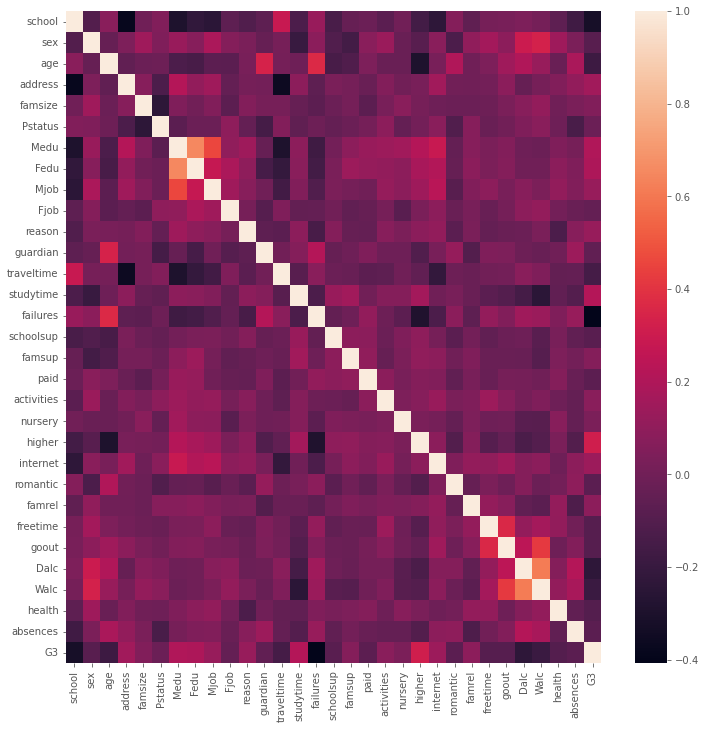

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))

corr_pearson = data_train.corr()
sns.heatmap(corr_pearson, ax=ax)

plt.show()

**Вывод:** мы закодировали признаки и избежали появления скоррелированных столбцов.

### Адаптивное заполнение:

**Разделяем данные:**

In [8]:
columns = data_train.columns[:-1]
columns_nans = []

for column in columns:
    
    if data_train[column].isna().sum() != 0:
        columns_nans.append(column)
        
columns_drop = columns_nans + ['G3']

In [9]:
data_nonans = data_train.dropna()
x_train = data_nonans.drop(columns=columns_drop).to_numpy()

x_predicts, y_trains = {}, {}

for column in columns_nans:
    
    pred_samples = data_train.loc[data_train[column].isna()].drop(columns=columns_drop)
    train_targets = data_nonans[[column]].to_numpy().ravel()
    y_trains[column] = train_targets.astype(np.int64)
    x_predicts[column] = pred_samples.to_numpy()

**Выбираем лучшие модели для заполнения:**

In [10]:
parametrs = {'n_neighbors': np.arange(1, 51),
             'weights': ['uniform', 'distance']}

estimators = {}

for column, y_train in y_trains.items():
    
    model = KNeighborsClassifier() if column != 'age' else KNeighborsRegressor()
    metric = 'accuracy' if column != 'age' else 'neg_mean_squared_error'
    
    gscv = GridSearchCV(model, parametrs, scoring=metric, n_jobs=-1)
    gscv.fit(x_train, y_train)
    
    estimators[column] = gscv.best_estimator_
    
    print(f'{column.upper()} {metric}: {np.round(gscv.best_score_, 3)};')

SEX accuracy: 0.679;
AGE neg_mean_squared_error: -1.523;
ADDRESS accuracy: 0.711;


**Заполняем данные:**

In [11]:
for column in columns_nans:
    
    prediction = estimators[column].predict(x_predicts[column])
    
    index = data_train.loc[data_train[column].isna(), column].index
    values = pd.Series(data=np.round(prediction), index=index)
    
    data_train.loc[:, column].fillna(value=values, inplace=True)

## Обучение алгоритмов.

**Разделение данных:**

In [12]:
x = data_train.to_numpy()[:, :-1]
y = data_train.to_numpy()[:, -1]

x_train, x_blend_test, y_train, y_blend_test = train_test_split(x, y, test_size=0.2,
                                                                random_state=state)
x_blend, x_test, y_blend, y_test = train_test_split(x_blend_test, y_blend_test, 
                                                    test_size=0.5,
                                                    random_state=state)

### 1. Регрессионная постановка задачи.

Мы предсказываем итоговую оценку(число от 0 до 20), и нам важно насколько сильно мы ошибаемся. Если брать в качестве метрики качества accuracy, то небольшие ошибки(15 вместо 16) будут искажать итоговую оценку качества так же сильно, как и сильные ошибки(0 вместо 20). Поэтому в качестве функции потерь и метрики качества была взята MSE, поскольку она чувствительна к тому, насколько сильно мы промахиваемся.  

В соответствии с выбранной функцией потерь, были взяты различные регрессионные модели, от самых слабых(KNN и Линейная регрессия) до достаточно сложной модели(Случайный лес).

**Подбор гиперпараметров:**

In [13]:
models = {'knn': KNeighborsRegressor(),
          'svr': SVR(),
          'rfr': RandomForestRegressor()}

model_params = {'knn': {'n_neighbors': np.arange(1, 41), 
                        'weights': ['uniform', 'distance']},
                'svr': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                        'C': np.arange(0.1, 10.1, 0.1)},
                'rfr': {'n_estimators': np.arange(100, 501, 100),
                        'max_depth': [(i + 1) * 50 for i in range(5)] + [None]}}

estimators_reg = {'reg': LinearRegression()}

for label, model in models.items():
    
    gscv = GridSearchCV(model, model_params[label], 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
    
    gscv.fit(x_train, y_train)
    
    estimators_reg[label] = gscv.best_estimator_
    
    print(f'{label.upper()} MSE: {(-1) * np.round(gscv.best_score_, 3)};')

KNN MSE: 8.959;
SVR MSE: 7.84;
RFR MSE: 7.675;


In [14]:
estimators_reg['reg'].fit(x_train, y_train)

prediction = estimators_reg['reg'].predict(x_test)

mse = mean_squared_error(y_test, np.round(prediction))

print(f'REG MSE: {np.round(mse, 3)};')

REG MSE: 5.283;


### 2. Классификационная постановка задачи.

In [15]:
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
models = {'knn': KNeighborsClassifier(),
          'svc': SVC(probability=True),
          'rfc': RandomForestClassifier(),
          'reg': LogisticRegression()}

model_params = {'knn': {'n_neighbors': np.arange(1, 41), 
                        'weights': ['uniform', 'distance']},
                'svc': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                        'C': np.arange(0.1, 10.1, 0.1),
                        'class_weight': [None, 'balanced']},
                'rfc': {'n_estimators': np.arange(100, 501, 100),
                        'max_depth': [(i + 1) * 50 for i in range(5)] + [None],
                        'class_weight' : ['balanced', 'balanced_subsample', None]},
                'reg': {'penalty': [None, 'l2', 'l1', 'elasticnet'],
                        'C': np.arange(0.1, 10.1, 0.1),
                        'class_weight': [None, 'balanced'],
                        'max_iter': np.arange(100, 501, 100)}}

estimators_cls = {}

for label, model in models.items():
    
    gscv = GridSearchCV(model, model_params[label], 
                        scoring='accuracy',
                        n_jobs=-1)
    
    gscv.fit(x_train, y_train)
    
    estimators_cls[label] = gscv.best_estimator_
    
    print(f'{label.upper()} accuracy: {np.round(gscv.best_score_, 3)};')

KNN accuracy: 0.193;
SVC accuracy: 0.19;
RFC accuracy: 0.185;
REG accuracy: 0.149;


## Постройте решение на основе подхода Blending

### 1. Регрессия.

In [17]:
meta_algorithm = LinearRegression()

blend_train, blend_test = None, None

for estimator in estimators_reg.values():
    
    train_predict = estimator.predict(x_blend)
    test_predict = estimator.predict(x_test)
    
    if blend_train is None:
        blend_train = train_predict[:, np.newaxis]
        blend_test = test_predict[:, np.newaxis]
        
    else:
        blend_train = np.hstack((blend_train, train_predict[:, np.newaxis]))
        blend_test = np.hstack((blend_test, test_predict[:, np.newaxis]))
        
blend_train, blend_test = np.round(blend_train), np.round(blend_test)

meta_algorithm.fit(blend_train, y_blend)

prediction = meta_algorithm.predict(blend_test)

mse = mean_squared_error(y_test, np.round(prediction))

print(f'BLENDING MSE: {np.round(mse, 3)};')

BLENDING MSE: 6.674;


### 2. Классификация.

In [33]:
blend_train, blend_test = None, None

for estimator in estimators_cls.values():
    
    train_predict = np.zeros((x_blend.shape[0], g3_range))
    test_predict = np.zeros((x_test.shape[0], g3_range))
    
    classes = estimator.classes_.astype(int)
    
    train_predict[:, classes] = estimator.predict_proba(x_blend)
    test_predict[:, classes] = estimator.predict_proba(x_test)
    
    if blend_train is None:
        blend_train = train_predict
        blend_test = test_predict
        
    else:
        blend_train = np.hstack((blend_train, train_predict))
        blend_test = np.hstack((blend_test, test_predict))
        
meta_algorithm = LogisticRegression()

meta_algorithm.fit(blend_train, y_blend)

prediction = np.round(meta_algorithm.predict(blend_test))

accuracy = accuracy_score(y_test, prediction)

print(f'BLENDING accuracy: {np.round(accuracy, 3)};')

BLENDING accuracy: 0.174;


## Постройте решение на основе подхода Stacking

Правила:
- Реализуйте пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Проведите оптимизацию пайплайна
- Оцените вклад каждого базового алгоритма в итоговое предсказание

In [34]:
class StackingModel:
    
    def __init__(self, meta_estimators, estimator, folder, floor=True,
                 track_importance=False):
        
        self.__track_importance = track_importance
        self.__estimators_cut = None
        self.__predictions = None
        self.__prediction = None
        self.__estimators = meta_estimators
        self.__estimator = estimator
        self.__folder = folder
        self.__line = '----------------------------------------'
        self.__floor = floor
        
    def fit(self, X, y, verbose=False):
        
        metadata = None
        
        for label, estimator in self.__estimators.items():
            
            if verbose:
                print(f'{self.__line}{self.__line}')
                
            column = np.zeros(X.shape[0])
            scores = np.array([])
            
            for train_index, test_index in self.__folder.split(X, y):
                
                estimator.fit(X[train_index], y[train_index])
                prediction = estimator.predict(X[test_index])
                
                column[test_index] = prediction
                
                if verbose:
                    
                    score = mean_squared_error(y[test_index], prediction)
                    scores = np.append(scores, score)
                    print(f'{label} MSE: {np.round(score, 3)};')
                    
            if verbose:
                print(f'{label} mean MSE: {np.round(scores.mean(), 3)}')
                    
            if metadata is None:
                metadata = column[:, np.newaxis]
                
            else:
                metadata = np.hstack((metadata, column[:, np.newaxis]))
                
        if verbose:
            print(f'{self.__line}{self.__line}')
                
        if self.__floor:
            metadata = np.round(metadata)
            
        for estimator in self.__estimators.values():
            estimator.fit(X, y)
            
        self.__estimator.fit(metadata, y)
        
        if self.__track_importance:
            
            self.__estimators_cut = {}
            
            for i, label in enumerate(self.__estimators.keys()):
            
                metadata_local = np.delete(metadata, i, axis=1)
                
                if self.__floor:
                    metadata_local = np.round(metadata_local)
                
                self.__estimators_cut[label] = clone(self.__estimator)
                self.__estimators_cut[label].fit(metadata_local, y)
        
    def predict(self, X):
        
        metadata = None
        
        for estimator in self.__estimators.values():
            
            predictions = estimator.predict(X)
            
            if metadata is None:
                metadata = predictions[:, np.newaxis]
                
            else:
                metadata = np.hstack((metadata, predictions[:, np.newaxis]))
                
        if self.__floor:
            metadata = np.round(metadata)
                
        prediction = self.__estimator.predict(metadata)
        
        if self.__track_importance:
            
            self.__predictions = {}
            
            for i, label in enumerate(self.__estimators.keys()):
            
                metadata_local = np.delete(metadata, i, axis=1)
                
                if self.__floor:
                    metadata_local = np.round(metadata_local)
                
                prediction = self.__estimators_cut[label].predict(metadata_local)
                
                if self.__floor:
                    prediction = np.round(prediction)
                
                self.__predictions[label] = prediction
        
        self.__prediction = np.round(prediction) if self.__floor else prediction
        
        return  self.__prediction
    
    def show_estimator_importance(self, y):
        
        if not self.__track_importance:
            raise RuntimeError("Model didn't track importances;")
            
        print(f'{self.__line}{self.__line}')
        
        model_score = mean_squared_error(y, self.__prediction)
        
        print(f'MODEL SCORE: {np.round(model_score, 3)};\n')
        
        for label, prediction in self.__predictions.items():
            
            score = mean_squared_error(y, prediction)
            
            delta = np.round(model_score - score, 3)
            
            print(f'{label.upper()}: FOLD SCORE: {np.round(score, 3)};', 
                  f'SCORE IMPACT: {delta};')
            
        print(f'{self.__line}{self.__line}')

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=state)

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
estimator = SVR(C=1.1)

sm = StackingModel(estimators_reg, estimator, skf, floor=True,
                   track_importance=True)
sm.fit(x_train, y_train)

prediction = sm.predict(x_test)

mse = mean_squared_error(y_test, prediction)

print(f'STACKING MSE: {np.round(mse, 3)};')

STACKING MSE: 7.286;


In [37]:
sm.show_estimator_importance(y_test)

--------------------------------------------------------------------------------
MODEL SCORE: 7.286;

REG: FOLD SCORE: 7.912; SCORE IMPACT: -0.626;
KNN: FOLD SCORE: 7.363; SCORE IMPACT: -0.077;
SVR: FOLD SCORE: 7.527; SCORE IMPACT: -0.242;
RFR: FOLD SCORE: 7.286; SCORE IMPACT: 0.0;
--------------------------------------------------------------------------------
